In [1]:
# https://www.kaggle.com/code/metric/santa-2023-metric
"""Evaluation metric for Santa 2023."""

import pandas as pd
from ast import literal_eval
from dataclasses import dataclass
from sympy.combinatorics import Permutation
from typing import Dict, List


class ParticipantVisibleError(Exception):
    pass


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        series_id_column_name: str,
        moves_column_name: str,
        puzzle_info_path: str,
) -> float:
    """Santa 2023 evaluation metric.

    Parameters
    ----------
    solution : pd.DataFrame

    submission : pd.DataFrame

    series_id_column_name : str

    moves_column_name : str

    Returns
    -------
    total_num_moves : int
    """
    if list(submission.columns) != [series_id_column_name, moves_column_name]:
        raise ParticipantVisibleError(
            f"Submission must have columns {series_id_column_name} and {moves_column_name}."
        )

    puzzle_info = pd.read_csv(puzzle_info_path, index_col='puzzle_type')
    total_num_moves = 0
    for sol, sub in zip(solution.itertuples(), submission.itertuples()):
        puzzle_id = getattr(sol, series_id_column_name)
        assert puzzle_id == getattr(sub, series_id_column_name)
        allowed_moves = literal_eval(puzzle_info.loc[sol.puzzle_type, 'allowed_moves'])
        allowed_moves = {k: Permutation(v) for k, v in allowed_moves.items()}
        puzzle = Puzzle(
            puzzle_id=puzzle_id,
            allowed_moves=allowed_moves,
            solution_state=sol.solution_state.split(';'),
            initial_state=sol.initial_state.split(';'),
            num_wildcards=sol.num_wildcards,
        )

        # Score submission row
        total_num_moves += score_puzzle(puzzle_id, puzzle, getattr(sub, moves_column_name))

    return total_num_moves


@dataclass
class Puzzle:
    """A permutation puzzle."""

    puzzle_id: str
    allowed_moves: Dict[str, List[int]]
    solution_state: List[str]
    initial_state: List[str]
    num_wildcards: int


def score_puzzle(puzzle_id, puzzle, sub_solution):
    """Score the solution to a permutation puzzle."""
    # Apply submitted sequence of moves to the initial state, from left to right
    moves = sub_solution.split('.')
    state = puzzle.initial_state
    for m in moves:
        power = 1
        if m[0] == "-":
            m = m[1:]
            power = -1
        try:
            p = puzzle.allowed_moves[m]
        except KeyError:
            raise ParticipantVisibleError(f"{m} is not an allowed move for {puzzle_id}.")
        state = (p ** power)(state)

    # Check that submitted moves solve puzzle
    num_wrong_facelets = sum(not(s == t) for s, t in zip(puzzle.solution_state, state))
    if num_wrong_facelets > puzzle.num_wildcards:
        raise ParticipantVisibleError(f"Submitted moves do not solve {puzzle_id}.")

    # The score for this instance is the total number of moves needed to solve the puzzle
    return len(moves)

- スコアは長さの和

In [3]:
import pandas as pd
from sympy.combinatorics import Permutation
from multiprocess import Pool, cpu_count

p = './santa-2023/'
path = pd.read_csv(p+'puzzles.csv')
info = pd.read_csv(p+'puzzle_info.csv')
sub = pd.read_csv(p+'sample_submission.csv')

In [4]:
path

,id,puzzle_type,solution_state,initial_state,num_wildcards
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0
...,...,...,...,...,...
393,393,globe_33/3,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,D;D;L;A;P;E;R;U;U;C;S;R;J;B;E;G;O;J;F;Q;R;E;D;...,0
394,394,globe_33/3,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,V;L;N;G;B;V;R;E;H;A;K;S;I;N;G;E;V;C;L;G;S;M;P;...,0
395,395,globe_33/3,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N12;N219;N227;N198;N4;N208;N214;N245;N56;N55;N...,0
396,396,globe_8/25,A;A;A;A;A;D;D;D;D;D;G;G;G;G;G;J;J;J;J;J;M;M;M;...,V;P;F;L;P;X;O;A;J;b;V;Y;D;Y;C;X;J;F;U;G;d;L;b;...,0


In [5]:
info

,puzzle_type,allowed_moves
0,cube_2/2/2,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
1,cube_3/3/3,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ..."
2,cube_4/4/4,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
3,cube_5/5/5,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
4,cube_6/6/6,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
5,cube_7/7/7,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
6,cube_8/8/8,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
7,cube_9/9/9,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
8,cube_10/10/10,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
9,cube_19/19/19,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."


In [6]:
sub

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


In [7]:
info['allowed_moves_count'] = info['allowed_moves'].map(lambda x: {k: Permutation(v) for k, v in eval(x).items()})
paths = pd.merge(path, info, how='left', on='puzzle_type')
paths = pd.merge(paths, sub, how='left', on='id')
paths['solution_state'] = paths['solution_state'].map(lambda x: x.split(';'))
paths['initial_state'] = paths['initial_state'].map(lambda x: x.split(';'))
paths['moves'] = paths['moves'].map(lambda x: x.split('.'))
paths.head(1)

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves,allowed_moves_count,moves
0,0,cube_2/2/2,"[A, A, A, A, B, B, B, B, C, C, C, C, D, D, D, ...","[D, E, D, A, E, B, A, B, C, A, C, A, D, C, D, ...",0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...","{'f0': (23)(2 19 21 8)(3 17 20 10)(4 6 7 5), '...","[r1, -f1]"


In [8]:
#Evaluation metric for Santa 2023 - https://www.kaggle.com/code/metric/santa-2023-metric
# modified - using combined paths & info dataframe

def getMoves(puzzle_id, moves, allowed_moves, state, solution_state, num_wildcards):
#     for m in moves:
#         power = 1
#         if m[0] == "-":
#             m = m[1:]
#             power = -1
#         p = allowed_moves[m]
#         state = (p ** power)(state)
#     num_wrong_facelets = sum(not(s == t) for s, t in zip(solution_state, state))
#     if num_wrong_facelets > num_wildcards:
#         print(f"Submitted moves do not solve {puzzle_id}.")
    return len(moves)

def score(sol):
    p = Pool(cpu_count()-1)
    ret = p.starmap(getMoves, sol[['id','moves','allowed_moves_count','initial_state','solution_state','num_wildcards']].values)
    p.close(); p.join()
    return sum(ret)

In [9]:
%%time
score(paths)

CPU times: total: 1.3 s
Wall time: 5.58 s


1220590

In [10]:
# Visualizing Changes
def pPositions(s):
    o = """
        Positions                              

             +--------+                               +--------+
             | .0.    .1. |                               | A    A |
             |   d1   |                               |   d1   |
             | .2.    .3. |                               | A    A |
    +--------+--------+--------+--------+    +--------+--------+--------+--------+
    | .16.    .17. | .4.    .5. | .8.    .9. | .12.    .13. |    | E    E | B    B | C    C | D    D |
    |   r1   |   f0   |   r0   |   f1   |    |   r1   |   f0   |   r0   |   f1   |
    | .18.    .19. | .6.    .7. | .10.    .11. | .14.    .15. |    | E    E | B    B | C    C | D    D |
    +--------+--------+--------+--------+    +--------+--------+--------+--------+
             | .20.    .21. |                               | F    F |
             |   d0   |                               |   d0   |
             | .22.    .23. |                               | F    F |
             +--------+                               +--------+
    """
    for i in range(len(s)):
        o = o.replace('.'+str(i)+'.', s[i])
    return o

def getMoves(args):
    puzzle_id, moves, allowed_moves, state, solution_state, num_wildcards = args
    print(f"allowed_moves: {allowed_moves}")
    for m in moves:
        print(f"move: {m}")
        power = 1
        if m[0] == "-":
            m = m[1:]
            power = -1
        p = allowed_moves[m]
        print(f"perm: {p}")
        state = (p ** power)(state)
        print(f"state: {state}")
        print(pPositions(state))
    
#     num_wrong_facelets = sum(not(s == t) for s, t in zip(solution_state, state))
#     if num_wrong_facelets > num_wildcards:
#         print(f"Submitted moves do not solve {puzzle_id}.")
    return len(moves)

getMoves(paths[['id','moves','allowed_moves_count','initial_state','solution_state','num_wildcards']].values[0])

allowed_moves: {'f0': Permutation(23)(2, 19, 21, 8)(3, 17, 20, 10)(4, 6, 7, 5), 'f1': Permutation(0, 18, 23, 9)(1, 16, 22, 11)(12, 13, 15, 14), 'r0': Permutation(1, 5, 21, 14)(3, 7, 23, 12)(8, 10, 11, 9), 'r1': Permutation(23)(0, 4, 20, 15)(2, 6, 22, 13)(16, 17, 19, 18), 'd0': Permutation(6, 18, 14, 10)(7, 19, 15, 11)(20, 22, 23, 21), 'd1': Permutation(23)(0, 1, 3, 2)(4, 16, 12, 8)(5, 17, 13, 9)}
move: r1
perm: (23)(0 4 20 15)(2 6 22 13)(16 17 19 18)
state: ['E', 'E', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'A', 'C', 'A', 'D', 'D', 'D', 'D', 'F', 'E', 'F', 'E', 'F', 'F', 'C', 'C']

        Positions                              

             +--------+                               +--------+
             | E    E |                               | A    A |
             |   d1   |                               |   d1   |
             | A    A |                               | A    A |
    +--------+--------+--------+--------+    +--------+--------+--------+--------+
    | F    E | B    B | 

2

In [11]:
# paths['moves'] = paths['moves'].map(lambda x: '.'.join(x))
# paths[['id','moves']].to_csv('submission.csv', index=False)

# 可視化

In [12]:
info.loc[0]

puzzle_type                                                   cube_2/2/2
allowed_moves          {'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...
allowed_moves_count    {'f0': (23)(2 19 21 8)(3 17 20 10)(4 6 7 5), '...
Name: 0, dtype: object

In [13]:
allowed_moves=eval(info.at[0,"allowed_moves"])
allowed_moves

{'f0': [0,
  1,
  19,
  17,
  6,
  4,
  7,
  5,
  2,
  9,
  3,
  11,
  12,
  13,
  14,
  15,
  16,
  20,
  18,
  21,
  10,
  8,
  22,
  23],
 'f1': [18,
  16,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  0,
  10,
  1,
  13,
  15,
  12,
  14,
  22,
  17,
  23,
  19,
  20,
  21,
  11,
  9],
 'r0': [0,
  5,
  2,
  7,
  4,
  21,
  6,
  23,
  10,
  8,
  11,
  9,
  3,
  13,
  1,
  15,
  16,
  17,
  18,
  19,
  20,
  14,
  22,
  12],
 'r1': [4,
  1,
  6,
  3,
  20,
  5,
  22,
  7,
  8,
  9,
  10,
  11,
  12,
  2,
  14,
  0,
  17,
  19,
  16,
  18,
  15,
  21,
  13,
  23],
 'd0': [0,
  1,
  2,
  3,
  4,
  5,
  18,
  19,
  8,
  9,
  6,
  7,
  12,
  13,
  10,
  11,
  16,
  17,
  14,
  15,
  22,
  20,
  23,
  21],
 'd1': [1,
  3,
  0,
  2,
  16,
  17,
  6,
  7,
  4,
  5,
  10,
  11,
  8,
  9,
  14,
  15,
  12,
  13,
  18,
  19,
  20,
  21,
  22,
  23]}

In [14]:
for k,v in allowed_moves.items():
    print(k, len(v))

f0 24
f1 24
r0 24
r1 24
d0 24
d1 24


In [15]:
print(allowed_moves)

{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11, 12, 13, 14, 15, 16, 20, 18, 21, 10, 8, 22, 23], 'f1': [18, 16, 2, 3, 4, 5, 6, 7, 8, 0, 10, 1, 13, 15, 12, 14, 22, 17, 23, 19, 20, 21, 11, 9], 'r0': [0, 5, 2, 7, 4, 21, 6, 23, 10, 8, 11, 9, 3, 13, 1, 15, 16, 17, 18, 19, 20, 14, 22, 12], 'r1': [4, 1, 6, 3, 20, 5, 22, 7, 8, 9, 10, 11, 12, 2, 14, 0, 17, 19, 16, 18, 15, 21, 13, 23], 'd0': [0, 1, 2, 3, 4, 5, 18, 19, 8, 9, 6, 7, 12, 13, 10, 11, 16, 17, 14, 15, 22, 20, 23, 21], 'd1': [1, 3, 0, 2, 16, 17, 6, 7, 4, 5, 10, 11, 8, 9, 14, 15, 12, 13, 18, 19, 20, 21, 22, 23]}


In [16]:
allowed_moves.keys()

dict_keys(['f0', 'f1', 'r0', 'r1', 'd0', 'd1'])

In [17]:
path["num_wildcards"].value_counts()

0      318
2       34
4       14
6       10
8        7
10       4
16       3
18       2
42       1
34       1
38       1
54       1
176      1
12       1
Name: num_wildcards, dtype: int64

In [18]:
path.at[0,"solution_state"]

'A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F'

In [19]:
path.at[0,"initial_state"]

'D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C'

In [45]:
len(path.at[0,"initial_state"].split(";"))

24

In [44]:
len(path.at[0,"solution_state"].split(";"))

24

In [20]:
sub

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


- `allowed_moves`: 許される動き。逆動作もOK。各移動は[配列形式](https://docs.sympy.org/latest/modules/combinatorics/permutations.html)で与えられた順列。
- `*_state`: 色の配置
- `num_wildcards`: 間違えていい数
- `moves`: 動作を`.`で繋ぐ。逆動作は`-`をつける

# permutation理解

In [288]:
from sympy.combinatorics import Permutation
p = Permutation([0, 2, 1])
p

Permutation(1, 2)

In [289]:
[i^p for i in range(p.size)]

[0, 2, 1]

In [290]:
# mapping 2 to p[2]
2^p

1

In [291]:
# mapping 2 to p[2]
p(2)

1

In [27]:
# ループされる順序だけが表示される
# 要素数1は表示されない
Permutation([1, 3, 2, 0])

Permutation(0, 1, 3)

In [31]:
Permutation(0,1,3)

Permutation(0, 1, 3)

In [32]:
Permutation(1, 2)(3, 5)

Permutation(1, 2)(3, 5)

In [35]:
Permutation(1, 2)(1, 3)(2, 3)

Permutation(1, 3)

In [37]:
Permutation(1, 2)(1, 3)(2, 3).list()

[0, 3, 2, 1]

In [36]:
Permutation([0, 3, 2, 1])

Permutation(1, 3)

In [99]:
(Permutation([2, 0, 1])**-1).list()

[1, 2, 0]

In [100]:
(Permutation([0, 3, 2, 1])**-1).list()

[0, 3, 2, 1]

In [106]:
(Permutation([2, 0,3, 1])**-1).list()

[1, 3, 0, 2]

In [107]:
# org=[2, 0, 1]
org=[2, 0,3, 1]
# org=[0, 3, 2, 1]
inv=[0]*len(org)
for i, o in enumerate(org):
    inv[o]=i
inv

[1, 3, 0, 2]

# AtCoder形式へ変換

In [2]:
import pandas as pd
import numpy as np

In [69]:
p = './santa-2023/'
puzzles = pd.read_csv(p+'puzzles.csv')
puzzle_info = pd.read_csv(p+'puzzle_info.csv')
sample_submission = pd.read_csv(p+'sample_submission.csv')

In [323]:
df=puzzles.merge(puzzle_info, on="puzzle_type")
df

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,..."
...,...,...,...,...,...,...
393,393,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,D;D;L;A;P;E;R;U;U;C;S;R;J;B;E;G;O;J;F;Q;R;E;D;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."
394,394,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,V;L;N;G;B;V;R;E;H;A;K;S;I;N;G;E;V;C;L;G;S;M;P;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."
395,395,globe_3/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N12;N219;N227;N198;N4;N208;N214;N245;N56;N55;N...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."
396,396,globe_8/25,A;A;A;A;A;D;D;D;D;D;G;G;G;G;G;J;J;J;J;J;M;M;M;...,V;P;F;L;P;X;O;A;J;b;V;Y;D;Y;C;X;J;F;U;G;d;L;b;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,..."


In [324]:
df["initial_state"]=df["initial_state"].str.split(";")

In [325]:
df["solution_state"]=df["solution_state"].str.split(";")

In [326]:
df["state_length"]=df["solution_state"].map(len)

In [327]:
df["allowed_moves"]=df["allowed_moves"].map(eval)

In [328]:
df["allowed_action_num"]=df["allowed_moves"].map(len)

In [329]:
df["perm_length"]=df["allowed_moves"].map(lambda x: len(list(x.values())[0]))

In [330]:
assert (df["state_length"]==df["perm_length"]).all()

In [331]:
from pathlib import Path
output_dir = Path(f"./data")
output_dir.mkdir(parents=True, exist_ok=True)
for i, row in df.iterrows():
    with open(output_dir / f"{row['id']}.txt", "w") as f:
        f.write(f'{row["puzzle_type"]}\n')
        f.write(f'{row["state_length"]}\n')
        f.write(f'{" ".join(row["initial_state"])}\n')
        f.write(f'{" ".join(row["solution_state"])}\n')
        f.write(f'{row["allowed_action_num"]}\n')
        for k,v in row["allowed_moves"].items():
            f.write(f"{k} {' '.join(map(str,v))}\n")
        f.write(f'{row["num_wildcards"]}\n')

# sample_submittionを分割

In [173]:
for i, row in submit.iterrows():
# for i, row in sample_submission.iterrows():
    filename=f"output/{i}.txt"
    with open(filename, "w") as f:
        f.write(row["moves"])

In [296]:
# for i, row in df.iterrows():
#     filename=f"subanswer/{row['id']}.txt"
#     with open(filename, "w") as f:
#         f.write(row["moves"])

In [114]:
# for i, row in sub.iterrows():
#     filename=f"sub/{row['id_sub']}.txt"
#     with open(filename, "w") as f:
#         f.write(row["moves"])

In [147]:
# for i, row in globe.iterrows():
#     filename=f"globe/{row['id']}.txt"
#     with open(filename, "w") as f:
#         f.write(row["moves"])

# デコード

In [148]:
import os
import pandas as pd
p = './santa-2023/'
sample_submission = pd.read_csv(p+'sample_submission.csv')

# https://www.kaggle.com/code/dinhttrandrise/bidirectional-brute-force-w-wildcards/notebook
# sample_submission = pd.read_csv('Bidirectional_Brute_Force_w_Wildcards.csv')

# https://www.kaggle.com/code/wrrosa/santa-2023-kociemba-s-two-phase-algo-1-116-550/output
# sample_submission = pd.read_csv('Kociemba_two_phase_algo.csv')

# https://www.kaggle.com/code/yunsuxiaozi/k-step-optimal-solution-santa/output?select=submission.csv
# sample_submission = pd.read_csv('K_step_optimal_solution.csv')

# https://www.kaggle.com/code/paulorzp/magic-cube-utilities/output
# sample_submission = pd.read_csv('Magic_Cube_Utilities.csv')
# →変化なし

# https://www.kaggle.com/code/seanbearden/kociemba-w-greedy-all-3x3x3-ensemble/output
# sample_submission = pd.read_csv('Kociemba_w_Greedy.csv')

# sample_submission = pd.read_csv('solver_submit.csv')
# sample_submission = pd.read_csv('submission.csv')
# sample_submission = pd.read_csv('solver_submit_stripe.csv')

# sample_submission = pd.read_csv("Solve_All_NxNxN_Cubes_w_Traditional_Solution_State.csv")

# https://www.kaggle.com/code/dinhttrandrise/k-step-optimal-w-random-prune
# sample_submission = pd.read_csv('k-step.csv')

# https://www.kaggle.com/code/dinhttrandrise/k-moves-replacement-w-wildcards/notebook
# sample_submission = pd.read_csv('kstep-w.csv')
# 変化なし

# sample_submission = pd.read_csv('Visualize Using pythreejs.csv')
# https://www.kaggle.com/code/dinhttrandrise/added-cancel-opposite-pairs
# sample_submission = pd.read_csv('Cancel Opposite Pairs.csv')

sample_submission = pd.read_csv('submission.csv')

In [149]:
case_num=398

In [174]:
submit=sample_submission.copy()
for i in range(case_num):
    filename=f"output/{i}.txt"
#     filename=f"globe/{i}.txt"
#     filename=f"output_best2/{i}.txt"
#     filename=f"tmp/solutions/{i}.txt"
    try:
        with open(filename) as f:
            ans=f.readline()
            if len(ans.split("."))<=len(submit.at[i, "moves"].split(".")):
                submit.at[i, "moves"]=ans
    except:
        print(f"no exist: {i}")

In [176]:
submit.to_csv("submission.csv", index=False)

In [175]:
score=submit["moves"].str.split(".").map(len).sum()
score

717460

In [171]:
score

717460

In [11]:
p = './santa-2023/'
puzzles = pd.read_csv(p+'puzzles.csv')
puzzle_info = pd.read_csv(p+'puzzle_info.csv')
puzzles=puzzles.merge(puzzle_info, on="puzzle_type")
puzzles=puzzles.merge(submit,on="id", how="left")

In [12]:
puzzles["length"]=puzzles["moves"].str.split(".").map(len)

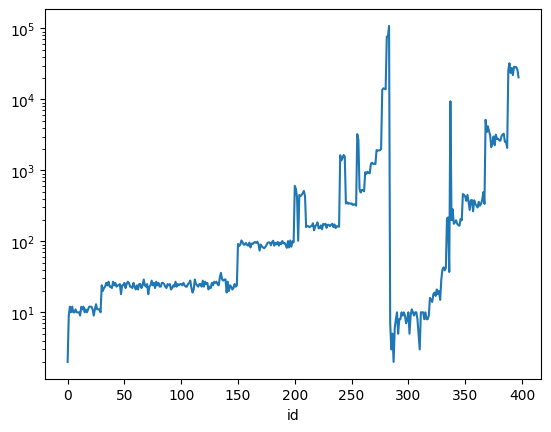

In [13]:
import matplotlib.pyplot as plt
puzzles.set_index("id")["length"].plot()#.plot(kind="bar")
plt.yscale("log")

In [14]:
puzzles.sort_values("length", ascending=False).head(10)

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves,moves,length
283,283,cube_33/33/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N1056;N4357;N3264;N3270;N924;N2183;N1095;N6526...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",f11.-d15.-r13.d0.-f0.f11.-r12.r29.-d4.-r28.-r2...,108590
281,281,cube_33/33/33,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,B;F;C;B;E;F;A;F;F;C;B;A;F;A;D;C;C;B;E;E;C;D;B;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",f0.f1.f2.f3.f4.f5.f6.f7.f8.f9.f10.f11.f12.f13....,76865
282,282,cube_33/33/33,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;...,F;B;A;F;A;C;B;B;C;B;B;A;E;F;A;E;E;E;B;E;B;F;E;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",f0.f0.d17.d18.d19.d20.d21.d22.d23.d24.d25.d26....,76737
389,389,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,H;A;P;K;G;N;U;G;D;V;E;L;D;O;E;Q;D;A;A;H;L;J;A;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",f51.f11.-f1.-f42.f47.f10.-f49.-r3.-f51.f11.-f1...,32334
393,393,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,D;D;L;A;P;E;R;U;U;C;S;R;J;B;E;G;O;J;F;Q;R;E;D;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",-f19.-f21.-f39.-f20.-f2.-f5.-f7.-r3.-f55.-f12....,28876
395,395,globe_3/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N12;N219;N227;N198;N4;N208;N214;N245;N56;N55;N...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",-r0.-f42.-f8.f18.f31.f42.f6.f63.f36.f8.f18.f10...,28642
394,394,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,V;L;N;G;B;V;R;E;H;A;K;S;I;N;G;E;V;C;L;G;S;M;P;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...,28367
391,391,globe_3/33,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N237;N257;N199;N215;N54;N261;N50;N6;N57;N32;N2...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",-f40.-f19.-f9.-f20.-f16.-f5.-f45.-f52.-f4.-f30...,27691
396,396,globe_8/25,A;A;A;A;A;D;D;D;D;D;G;G;G;G;G;J;J;J;J;J;M;M;M;...,V;P;F;L;P;X;O;A;J;b;V;Y;D;Y;C;X;J;F;U;G;d;L;b;...,0,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...,26252
388,388,globe_3/33,A;A;A;A;A;A;C;C;C;C;C;C;E;E;E;E;E;E;G;G;G;G;G;...,G;Q;G;D;E;T;E;N;U;H;H;U;O;F;T;B;S;M;A;N;D;V;V;...,6,"{'r0': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...",-f14.f23.-r1.f10.-f22.-f43.f4.f38.f22.f52.-f14...,25824


In [15]:
puzzles["solu"]=puzzles["solution_state"].str[:6]

In [16]:
puzzles.groupby(["puzzle_type", "solu"])["length"].agg(["size","sum","mean","min","max"])

size     sum           mean     min     max
puzzle_type    solu                                               
cube_10/10/10  A;A;A;     5    9671    1934.200000    1899    2003
cube_19/19/19  A;A;A;     4   55955   13988.750000   13649   14335
cube_2/2/2     A;A;A;    20     204      10.200000       2      12
               A;B;A;     5      56      11.200000      10      13
               N0;N1;     5      55      11.000000       9      12
cube_3/3/3     A;A;A;   100    2409      24.090000      18      29
               A;B;A;    10     284      28.400000      24      36
               N0;N1;    10     228      22.800000      19      27
cube_33/33/33  A;A;A;     1   76865   76865.000000   76865   76865
               A;B;A;     1   76737   76737.000000   76737   76737
               N0;N1;     1  108590  108590.000000  108590  108590
cube_4/4/4     A;A;A;    50    4592      91.840000      74     103
               A;B;A;     5    2118     423.600000     102     605
               N0;N1;     5    2312     462.400000     434     513
cube_5/5/5     A;A;A;    25    4131     165.240000     143     185
               A;B;A;     5     814     162.800000     154     173
               N0;N1;     5    7731    1546.200000    1385    1645
cube_6/6/6     A;A;A;    10    3373     337.300000     319     356
               A;B;A;     1    3241    3241.000000    3241    3241
               N0;N1;     1    2708    2708.000000    2708    2708
cube_7/7/7     A;A;A;     5    2605     521.000000     488     552
cube_8/8/8     A;A;A;     5    4627     925.400000     895     958
cube_9/9/9     A;A;A;     5    6222    1244.400000    1225    1281
globe_1/16     A;A;A;     5    2169     433.800000     372     463
globe_1/8      A;A;C;     5    1042     208.400000     177     284
               N0;N1;     5     917     183.400000     166     207
globe_2/6      A;A;A;     5    1666     333.200000     265     382
globe_3/33     A;A;A;     6  160995   26832.500000   22015   32334
               N0;N1;     2   56333   28166.500000   27691   28642
globe_3/4      A;A;C;    10    3563     356.300000     300     492
               N0;N1;     5   19526    3905.200000    3144    5160
globe_6/10     A;A;A;     5   13617    2723.400000    2074    3285
globe_6/4      A;A;D;     5   13058    2611.600000    2129    3186
globe_6/8      A;A;D;     5   13853    2770.600000    2618    3029
globe_8/25     A;A;A;     2   46707   23353.500000   20455   26252
wreath_100/100 C;A;A;     1    9418    9418.000000    9418    9418
wreath_12/12   C;A;A;    10     173      17.300000      14      21
wreath_21/21   C;A;A;     5     193      38.600000      29      43
wreath_33/33   C;A;A;     3     465     155.000000      37     217
wreath_6/6     C;A;C;    20     150       7.500000       2      11
wreath_7/7     C;A;C;    15     128       8.533333       3      10

In [17]:
puzzles["t"]=puzzles["puzzle_type"].str[:4]
puzzles.groupby("t")["length"].agg(["sum", "mean", "min", "max"])

,sum,mean,min,max
t,,,,
cube,375528,1322.281690,2,108590
glob,333446,5557.433333,166,32334
wrea,10527,194.944444,2,9418


In [18]:
puzzles.drop_duplicates(subset=["puzzle_type", "solution_state"])

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves,moves,length,solu,t
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...",r1.-f1,2,A;A;A;,cube
20,20,cube_2/2/2,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N22;N0;N1;N2;N12;N17;N20;N5;N4;N13;N3;N21;N16;...,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...",-r1.d0.-d1.-f1.-r0.-f1.d0.r1.d0.-r1.d0.d0,12,N0;N1;,cube
25,25,cube_2/2/2,A;B;A;B;B;C;B;C;C;D;C;D;D;E;D;E;E;F;E;F;F;A;F;A,C;F;B;D;F;A;E;D;D;E;D;C;E;A;B;F;C;A;F;E;A;B;B;C,0,"{'f0': [0, 1, 19, 17, 6, 4, 7, 5, 2, 9, 3, 11,...",r0.r0.d0.-f0.d0.-f0.-d1.-r0.f0.-r0.f0.f0.r0,13,A;B;A;,cube
30,30,cube_3/3/3,A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;...,A;A;E;C;F;F;C;C;C;D;B;D;D;B;A;B;F;F;A;E;B;D;E;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ...",-d2.-f0.-d2.-r1.r0.d2.f2.-d1.r1.-d0.r0.d0.r2.-...,24,A;A;A;,cube
130,130,cube_3/3/3,A;B;A;B;A;B;A;B;A;B;C;B;C;B;C;B;C;B;C;D;C;D;C;...,C;B;D;B;B;C;F;E;A;B;D;D;B;C;A;A;E;B;E;F;A;F;A;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ...",d2.f2.-d2.f2.d2.f0.d2.r2.d0.-f2.-f2.r0.d2.-r2....,26,A;B;A;,cube
140,140,cube_3/3/3,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N33;N7;N42;N19;N4;N52;N9;N48;N0;N38;N43;N29;N2...,6,"{'f0': [0, 1, 2, 3, 4, 5, 44, 41, 38, 15, 12, ...",-r0.-r2.f0.d1.-r0.d2.f0.d2.-r2.-r2.f2.d2.r1.-f...,19,N0;N1;,cube
150,150,cube_4/4/4,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;...,B;A;A;A;C;B;C;F;A;C;A;D;F;D;E;A;D;C;A;B;F;A;B;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-d0.-r3.-r3.-f3.-f2.-f3.-f2.-r0.-r1.d0.-f0.-f1...,92,A;A;A;,cube
200,200,cube_4/4/4,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,C;A;A;B;E;E;C;E;D;B;B;C;E;D;C;A;F;A;C;F;F;D;D;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",r0.d1.-d2.-f2.r3.-f2.-f3.d2.-d1.-r0.-f1.-f3.d2...,605,A;B;A;,cube
205,205,cube_4/4/4,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N3;N33;N20;N0;N50;N85;N53;N72;N7;N22;N41;N66;N...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-r0.r3.f0.-f1.-f2.r3.-f2.r1.-r2.-r3.d0.-f2.f3....,434,N0;N1;,cube
210,210,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,A;D;D;B;E;B;B;E;D;F;C;B;F;F;F;F;E;D;A;D;F;A;A;...,0,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",f3.f4.r0.r0.r1.r1.d0.d0.d1.d1.-r0.-f3.-f4.r1.r...,159,A;A;A;,cube


In [19]:
puzzles[(puzzles["num_wildcards"]!=0) & (puzzles["puzzle_type"]=="cube_5/5/5")]

,id,puzzle_type,solution_state,initial_state,num_wildcards,allowed_moves,moves,length,solu,t
211,211,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,C;D;F;E;B;E;A;F;A;A;E;B;C;F;C;F;E;A;D;D;E;F;A;...,10,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-r3.-r3.-r4.-r4.d0.d0.d1.d1.r0.r1.r1.-r4.-f0.-...,165,A;A;A;,cube
215,215,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,D;E;E;E;A;F;F;E;C;C;F;A;A;D;C;D;D;F;E;C;B;B;F;...,6,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",r3.-r4.f0.f0.f1.f1.r0.-d0.-d1.-f3.-f4.r0.r0.-f...,166,A;A;A;,cube
218,218,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,B;B;E;F;C;D;C;E;F;D;D;B;A;C;F;E;A;A;C;A;C;E;D;...,2,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-f3.-f4.-r3.-r4.f1.f1.-r0.-d3.-d4.-r0.-r1.f0.f...,163,A;A;A;,cube
219,219,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,A;F;D;B;F;D;E;E;E;D;A;A;C;E;E;C;B;D;B;F;D;A;A;...,2,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-r0.-r1.-f0.-f1.-d0.r0.r0.r1.r1.-f4.-f4.-r3.-r...,170,A;A;A;,cube
227,227,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,D;B;B;D;F;E;C;E;C;D;F;D;F;E;E;A;B;A;A;F;A;F;C;...,6,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-d0.-d1.r4.f4.f3.r0.r1.f4.r4.r3.-f4.-f4.r4.r3....,177,A;A;A;,cube
234,234,cube_5/5/5,A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;A;...,E;D;B;C;E;E;D;A;F;D;E;A;F;C;A;C;B;F;C;C;E;E;D;...,16,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",d3.d4.f0.f1.-d0.-d3.-d3.-d4.-d4.r0.r1.d0.d1.f2...,159,A;A;A;,cube
241,241,cube_5/5/5,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N25;N126;N110;N44;N145;N130;N141;N57;N31;N115;...,2,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",f3.-r1.r3.d3.r0.-f0.d2.-d4.r2.r3.r3.-d3.-r3.d4...,1385,N0;N1;,cube
244,244,cube_5/5/5,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N4;N23;N72;N5;N29;N105;N118;N32;N41;N1;N97;N11...,10,"{'f0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",-f0.r3.f0.-r1.d1.-d2.-d3.-r2.f0.-d1.-d1.-d4.f1...,1573,N0;N1;,cube


In [121]:
def do_action(state: list[str], action_id: str, allowed_moves: dict[str, list[int]]):
    s=state.copy()
    if action_id[0]=="-":
        action = allowed_moves[action_id[1:]]
        for i,a in enumerate(action):
            s[a]=state[i]
    else:
        action = allowed_moves[action_id]
        for i,a in enumerate(action):
            s[i]=state[a]
    return s

def simulate(state: str, actions: str, allowed_moves: str):
    s=state.split(";")
    allowed=eval(allowed_moves)
    for a in actions.split("."):
        s = do_action(s, a, allowed)
    return ";".join(s)
def mistakes(state1, state2):
    return sum(i!=j for i,j in zip(state1.split(";"), state2.split(";")))

# CUBE

In [408]:
# np.array(puzzles.loc[30, "solution_state"].split(";")).reshape((6,-1))
np.array(puzzles.loc[130, "solution_state"].split(";")).reshape((6,-1))
# A;B;A;
# B;A;B;
# A;B;A;

array([['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A'],
       ['B', 'C', 'B', 'C', 'B', 'C', 'B', 'C', 'B'],
       ['C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C'],
       ['D', 'E', 'D', 'E', 'D', 'E', 'D', 'E', 'D'],
       ['E', 'F', 'E', 'F', 'E', 'F', 'E', 'F', 'E'],
       ['F', 'A', 'F', 'A', 'F', 'A', 'F', 'A', 'F']], dtype='<U1')

In [409]:
np.array(puzzles.loc[200, "solution_state"].split(";")).reshape((6,-1))
# A;B;A;B;
# A;B;A;B;
# A;B;A;B;
# A;B;A;B;

array([['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A',
        'B', 'A', 'B'],
       ['B', 'C', 'B', 'C', 'B', 'C', 'B', 'C', 'B', 'C', 'B', 'C', 'B',
        'C', 'B', 'C'],
       ['C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C',
        'D', 'C', 'D'],
       ['D', 'E', 'D', 'E', 'D', 'E', 'D', 'E', 'D', 'E', 'D', 'E', 'D',
        'E', 'D', 'E'],
       ['E', 'F', 'E', 'F', 'E', 'F', 'E', 'F', 'E', 'F', 'E', 'F', 'E',
        'F', 'E', 'F'],
       ['F', 'A', 'F', 'A', 'F', 'A', 'F', 'A', 'F', 'A', 'F', 'A', 'F',
        'A', 'F', 'A']], dtype='<U1')

In [410]:
puzzles.loc[235, "solution_state"]
# A;B;A;B;A;
# B;A;B;A;B;
# A;B;A;B;A;
# B;A;B;A;B;
# A;B;A;B;A;

'A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;C;B;C;B;C;B;C;B;C;B;C;B;C;B;C;B;C;B;C;B;C;B;C;B;C;D;C;D;C;D;C;D;C;D;C;D;C;D;C;D;C;D;C;D;C;D;C;D;C;D;E;D;E;D;E;D;E;D;E;D;E;D;E;D;E;D;E;D;E;D;E;D;E;D;E;F;E;F;E;F;E;F;E;F;E;F;E;F;E;F;E;F;E;F;E;F;E;F;E;F;A;F;A;F;A;F;A;F;A;F;A;F;A;F;A;F;A;F;A;F;A;F;A;F'

In [45]:
np.array(puzzles.loc[240, "solution_state"].split(";")).reshape((6,-1))

array([['N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9',
        'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18',
        'N19', 'N20', 'N21', 'N22', 'N23', 'N24'],
       ['N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33',
        'N34', 'N35', 'N36', 'N37', 'N38', 'N39', 'N40', 'N41', 'N42',
        'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49'],
       ['N50', 'N51', 'N52', 'N53', 'N54', 'N55', 'N56', 'N57', 'N58',
        'N59', 'N60', 'N61', 'N62', 'N63', 'N64', 'N65', 'N66', 'N67',
        'N68', 'N69', 'N70', 'N71', 'N72', 'N73', 'N74'],
       ['N75', 'N76', 'N77', 'N78', 'N79', 'N80', 'N81', 'N82', 'N83',
        'N84', 'N85', 'N86', 'N87', 'N88', 'N89', 'N90', 'N91', 'N92',
        'N93', 'N94', 'N95', 'N96', 'N97', 'N98', 'N99'],
       ['N100', 'N101', 'N102', 'N103', 'N104', 'N105', 'N106', 'N107',
        'N108', 'N109', 'N110', 'N111', 'N112', 'N113', 'N114', 'N115',
        'N116', 'N117', 'N118', 'N119', 'N120', 'N121', 'N122', 'N

In [99]:
df.at[3, "moves"]+".f1.f1.r1.r1.f1.f1.r1.r1"

'-d0.-d1.-f3.-f3.d0.r3.d0.d1.f3.f2.-d3.f0.-f3.-f3.d0.-r0.-r1.d0.d1.d0.d1.r3.-r0.-r1.r0.r1.r0.r1.-d3.-d2.-d3.-d2.d0.r0.r1.r0.r1.d0.-f0.-d3.-d2.-d3.-d2.-r3.-r2.-r3.-r2.-d0.f0.f0.-f3.-f2.-f3.-f2.-d3.-r3.-r2.-r3.-r2.f0.f1.f0.f1.d3.-f3.-f3.d3.-r3.-r2.-r3.-r2.f0.r3.d0.-r3.-r3.f0.-r3.f3.r0.-d3.-d3.f0.d3.-f3.-f3.r0.r0.d3.f0.f0.-f3.-f3.-d3.f0.f0.-f3.-f3.-d3.-d3.f1.f1.r1.r1.f1.f1.r1.r1'

In [245]:
pid=203
# pid=255
# pid=283
s=simulate(
    puzzles.loc[pid, "initial_state"],
#     df.loc[df["id"]==pid*1000, "moves"].iat[0]+".f1.f1.r1.r1.f1.f1.r1.r1",
    df.loc[df["id"]==pid*1000, "moves"].iat[0],
    puzzles.at[pid, "allowed_moves"],
)
mistakes(s, puzzles.loc[pid, "solution_state"])

12

In [494]:
# pid=204
# op=puzzles.at[pid, "allowed_moves"]

# d0={}
# s=puzzles.at[pid, "initial_state"]
# for i,a in enumerate(puzzles.loc[puzzles["id"]==pid, "moves"].iat[0].split(".")):
#     s=simulate(s,a,op)
#     d0[s]=i

# d0_n={}
# for a in eval(op).keys():
#     for m in ["", "-"]:
#         for s,i in d0.items():
#             t=simulate(s,f"{m}{a}",op)
#             d0_n[t]=i

# d1={}
# s=puzzles.at[pid, "initial_state"]
# for i,a in enumerate(df.loc[df["id"]==pid*1000, "moves"].iat[0].split(".")):
#     s=simulate(s,a,op)
#     d1[s]=i

# d1_n={}
# for a in eval(op).keys():
#     for m in ["", "-"]:
#         for s,i in d1.items():
#             t=simulate(s,f"{m}{a}",op)
#             d1_n[t]=i

In [495]:
# d1_all=d1|d1_n
# for k in d0.keys()|d0_n.keys():
#     if k in d1_all:
#         print(k, d1_all[k])

## subproblem

In [103]:
def inverse_action(action):
    return ".".join(reversed([(a[1:] if a[0]=="-" else "-"+a) for a in action.split(".")]))

In [110]:
df=pd.read_csv("subproblem.csv")
df

,id,puzzle_type,moves,initial_state,solution_state,num_wildcards
0,200000,cube_4/4/4,d0.-r0.-r1.d0.-f3.-f2.r0.d3.d2.-r3.-r3.f3.-f3....,A;B;A;B;A;A;A;B;A;B;B;B;A;B;A;B;B;C;B;C;B;C;B;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0
1,201000,cube_4/4/4,d0.d1.d0.d1.-r3.-r3.f3.f2.-r3.-r3.-d0.-d1.f3.f...,A;B;A;B;A;A;A;B;A;B;B;B;A;B;A;B;B;C;B;C;B;C;C;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0
2,202000,cube_4/4/4,-d0.-f0.-d0.-d1.f3.d3.d2.f3.f2.f3.-r0.-r1.-d3....,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;B;B;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0
3,203000,cube_4/4/4,-d0.-d1.-f3.-f3.d0.r3.d0.d1.f3.f2.-d3.f0.-f3.-...,A;B;A;B;A;B;B;B;A;A;A;B;A;B;A;B;B;C;B;C;B;C;C;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,10
4,204000,cube_4/4/4,d0.d1.d0.d1.r0.r1.f3.f2.r3.-f3.d3.d2.-d3.-d3.d...,A;B;A;B;A;A;B;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;C;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0
5,205000,cube_4/4/4,f3.f2.d0.d1.r0.r1.d3.d2.-r3.-r3.f3.f2.-d3.-d3....,N0;N1;N2;N3;N4;N9;N5;N7;N8;N6;N10;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,0
6,206000,cube_4/4/4,d0.d1.-f3.-f2.-f3.-f2.r0.r0.-d3.-d3.-r3.-r3.d3...,N0;N1;N2;N3;N4;N10;N5;N7;N8;N6;N9;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,10
7,207000,cube_4/4/4,-r0.-r1.-d0.-r3.d0.d1.d0.d1.-r0.-f0.-f1.r0.r0....,N0;N1;N2;N3;N4;N9;N5;N7;N8;N10;N6;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,0
8,208000,cube_4/4/4,d0.d1.d0.d1.f3.f2.-d3.-d3.-r0.-r1.-f3.-f3.d3.d...,N0;N1;N2;N3;N4;N6;N10;N7;N8;N5;N9;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,6
9,209000,cube_4/4/4,d0.d1.d0.d1.-r0.-r1.-f3.-f2.-d0.f3.f2.r0.r0.-d...,N0;N1;N2;N3;N4;N5;N10;N7;N8;N6;N9;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,0


In [111]:
df["inv"]=df["moves"].map(inverse_action)

In [112]:
df["orgid"]=df["id"]//1000

In [113]:
sub=submit.merge(df, left_on="id", right_on="orgid", suffixes=("","_sub"))
sub["moves"]=sub["inv"]+"."+sub["moves"]

In [108]:
sub

,id,moves,id_sub,puzzle_type,moves_sub,initial_state,solution_state,num_wildcards,inv,orgid
0,200,-r0.-r0.-d0.-d0.-f0.-f0.-d0.-d0.f3.f3.-d3.-f0....,200000,cube_4/4/4,d0.-r0.-r1.d0.-f3.-f2.r0.d3.d2.-r3.-r3.f3.-f3....,A;B;A;B;A;A;A;B;A;B;B;B;A;B;A;B;B;C;B;C;B;C;B;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0,-r0.-r0.-d0.-d0.-f0.-f0.-d0.-d0.f3.f3.-d3.-f0....,200
1,201,d3.d3.f3.f3.d3.d3.-f0.-f0.r3.r3.f3.f3.d3.-r3.-...,201000,cube_4/4/4,d0.d1.d0.d1.-r3.-r3.f3.f2.-r3.-r3.-d0.-d1.f3.f...,A;B;A;B;A;A;A;B;A;B;B;B;A;B;A;B;B;C;B;C;B;C;C;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0,d3.d3.f3.f3.d3.d3.-f0.-f0.r3.r3.f3.f3.d3.-r3.-...,201
2,202,-d3.r3.r3.-r0.-r0.d3.-r0.-r0.d0.-d3.r3.r3.r0.-...,202000,cube_4/4/4,-d0.-f0.-d0.-d1.f3.d3.d2.f3.f2.f3.-r0.-r1.-d3....,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;B;B;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0,-d3.r3.r3.-r0.-r0.d3.-r0.-r0.d0.-d3.r3.r3.r0.-...,202
3,203,d3.d3.f3.f3.-f0.-f0.d3.f3.f3.-f0.-f0.-d3.-r0.-...,203000,cube_4/4/4,-d0.-d1.-f3.-f3.d0.r3.d0.d1.f3.f2.-d3.f0.-f3.-...,A;B;A;B;A;B;B;B;A;A;A;B;A;B;A;B;B;C;B;C;B;C;C;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,10,d3.d3.f3.f3.-f0.-f0.d3.f3.f3.-f0.-f0.-d3.-r0.-...,203
4,204,d0.f3.f3.-d0.r3.r3.f3.f3.-d0.-d3.r3.r3.d3.-r0....,204000,cube_4/4/4,d0.d1.d0.d1.r0.r1.f3.f2.r3.-f3.d3.d2.-d3.-d3.d...,A;B;A;B;A;A;B;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;C;...,A;B;A;B;A;B;A;B;A;B;A;B;A;B;A;B;B;C;B;C;B;C;B;...,0,d0.f3.f3.-d0.r3.r3.f3.f3.-d0.-d3.r3.r3.d3.-r0....,204
5,205,d3.-f0.-f0.d0.r3.r3.f3.f3.d3.r3.r3.f3.f3.-f0.-...,205000,cube_4/4/4,f3.f2.d0.d1.r0.r1.d3.d2.-r3.-r3.f3.f2.-d3.-d3....,N0;N1;N2;N3;N4;N9;N5;N7;N8;N6;N10;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,0,d3.-f0.-f0.d0.r3.r3.f3.f3.d3.r3.r3.f3.f3.-f0.-...,205
6,206,r3.r3.-r0.-r0.f3.f3.r3.r3.d3.f3.f3.-d3.f3.f3.-...,206000,cube_4/4/4,d0.d1.-f3.-f2.-f3.-f2.r0.r0.-d3.-d3.-r3.-r3.d3...,N0;N1;N2;N3;N4;N10;N5;N7;N8;N6;N9;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,10,r3.r3.-r0.-r0.f3.f3.r3.r3.d3.f3.f3.-d3.f3.f3.-...,206
7,207,d0.-d3.r3.r3.d3.d3.f3.f3.-f0.-f0.-d0.-r0.-r0.-...,207000,cube_4/4/4,-r0.-r1.-d0.-r3.d0.d1.d0.d1.-r0.-f0.-f1.r0.r0....,N0;N1;N2;N3;N4;N9;N5;N7;N8;N10;N6;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,0,d0.-d3.r3.r3.d3.d3.f3.f3.-f0.-f0.-d0.-r0.-r0.-...,207
8,208,-d3.f3.f3.r3.r3.f3.f3.r3.r3.d3.d3.r3.r3.-r0.-r...,208000,cube_4/4/4,d0.d1.d0.d1.f3.f2.-d3.-d3.-r0.-r1.-f3.-f3.d3.d...,N0;N1;N2;N3;N4;N6;N10;N7;N8;N5;N9;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,6,-d3.f3.f3.r3.r3.f3.f3.r3.r3.d3.d3.r3.r3.-r0.-r...,208
9,209,f3.f3.d3.d3.-r0.-r0.d0.r3.r3.-f0.-f0.-d0.-r0.-...,209000,cube_4/4/4,d0.d1.d0.d1.-r0.-r1.-f3.-f2.-d0.f3.f2.r0.r0.-d...,N0;N1;N2;N3;N4;N5;N10;N7;N8;N6;N9;N11;N12;N13;...,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,0,f3.f3.d3.d3.-r0.-r0.d0.r3.r3.-f0.-f0.-d0.-r0.-...,209


In [109]:
df=df.merge(puzzle_info, on="puzzle_type")

In [95]:
df["initial_state"]=df["initial_state"].str.split(";")

In [96]:
df["solution_state"]=df["solution_state"].str.split(";")

In [97]:
df["state_length"]=df["solution_state"].map(len)

In [98]:
df["allowed_moves"]=df["allowed_moves"].map(eval)

In [99]:
df["allowed_action_num"]=df["allowed_moves"].map(len)

In [100]:
df["perm_length"]=df["allowed_moves"].map(lambda x: len(list(x.values())[0]))

In [102]:
from pathlib import Path
output_dir = Path(f"./data")
output_dir.mkdir(parents=True, exist_ok=True)
for i, row in df.iterrows():
    with open(output_dir / f"{row['id']}.txt", "w") as f:
        f.write(f'{row["puzzle_type"]}\n')
        f.write(f'{row["state_length"]}\n')
        f.write(f'{" ".join(row["initial_state"])}\n')
        f.write(f'{" ".join(row["solution_state"])}\n')
        f.write(f'{row["allowed_action_num"]}\n')
        for k,v in row["allowed_moves"].items():
            f.write(f"{k} {' '.join(map(str,v))}\n")
        f.write(f'{row["num_wildcards"]}\n')

In [81]:
# [200000, 201000, 202000, 203000, 204000, 205000, 206000, 207000, 208000, 209000,
# 240000, 241000, 242000, 243000, 244000, 255000, 256000, 283000]

In [133]:
import numpy as np
state=df.at[0,"solution_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print("".join(r))

print("")
state=df.at[0,"initial_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print("".join(r))

ABABABABABABABAB
BCBCBCBCBCBCBCBC
CDCDCDCDCDCDCDCD
DEDEDEDEDEDEDEDE
EFEFEFEFEFEFEFEF
FAFAFAFAFAFAFAFA

ABABAAABABBBABAB
BCBCBCBCBBCCBCBC
CDCDCDDDCCCDCDCD
DEDEDDEEDDEEDEDE
EFEFEFEFEFEFEFEF
FAFAFFAAFAFAFAFA


In [139]:
tmp=simulate(
    df.at[0,"initial_state"],
    "r0.f0.d0.r0.f0.d0.r0.f0.d0",
    puzzle_info.at[2, "allowed_moves"]
)
for r in np.array(tmp.split(";")).reshape((6,-1)):
    print("".join(r))

ABABAAABABBBDFFF
BEFEEBCBDCBCCDDD
EFFFFDCAADCBAAAA
FEDEBDEECDEECCCA
EFEDEFEFEFEABCDC
BDDDBAFCBFADFCCC


In [446]:
state=df.at[0,"solution_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print(r.reshape((4,4)))

print("")
state=df.at[0,"initial_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print(r.reshape((4,4)))

[['A' 'B' 'A' 'B']
 ['A' 'B' 'A' 'B']
 ['A' 'B' 'A' 'B']
 ['A' 'B' 'A' 'B']]
[['B' 'C' 'B' 'C']
 ['B' 'C' 'B' 'C']
 ['B' 'C' 'B' 'C']
 ['B' 'C' 'B' 'C']]
[['C' 'D' 'C' 'D']
 ['C' 'D' 'C' 'D']
 ['C' 'D' 'C' 'D']
 ['C' 'D' 'C' 'D']]
[['D' 'E' 'D' 'E']
 ['D' 'E' 'D' 'E']
 ['D' 'E' 'D' 'E']
 ['D' 'E' 'D' 'E']]
[['E' 'F' 'E' 'F']
 ['E' 'F' 'E' 'F']
 ['E' 'F' 'E' 'F']
 ['E' 'F' 'E' 'F']]
[['F' 'A' 'F' 'A']
 ['F' 'A' 'F' 'A']
 ['F' 'A' 'F' 'A']
 ['F' 'A' 'F' 'A']]

[['A' 'B' 'A' 'B']
 ['A' 'A' 'A' 'B']
 ['A' 'B' 'B' 'B']
 ['A' 'B' 'A' 'B']]
[['B' 'C' 'B' 'C']
 ['B' 'C' 'B' 'C']
 ['B' 'B' 'C' 'C']
 ['B' 'C' 'B' 'C']]
[['C' 'D' 'C' 'D']
 ['C' 'D' 'D' 'D']
 ['C' 'C' 'C' 'D']
 ['C' 'D' 'C' 'D']]
[['D' 'E' 'D' 'E']
 ['D' 'D' 'E' 'E']
 ['D' 'D' 'E' 'E']
 ['D' 'E' 'D' 'E']]
[['E' 'F' 'E' 'F']
 ['E' 'F' 'E' 'F']
 ['E' 'F' 'E' 'F']
 ['E' 'F' 'E' 'F']]
[['F' 'A' 'F' 'A']
 ['F' 'F' 'A' 'A']
 ['F' 'A' 'F' 'A']
 ['F' 'A' 'F' 'A']]


In [450]:
state=df.at[23,"solution_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print(r.reshape((33,33)))

print("")
state=df.at[23,"initial_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print(r.reshape((33,33)))

[['N0' 'N1' 'N2' ... 'N30' 'N31' 'N32']
 ['N33' 'N34' 'N35' ... 'N63' 'N64' 'N65']
 ['N66' 'N67' 'N68' ... 'N96' 'N97' 'N98']
 ...
 ['N990' 'N991' 'N992' ... 'N1020' 'N1021' 'N1022']
 ['N1023' 'N1024' 'N1025' ... 'N1053' 'N1054' 'N1055']
 ['N1056' 'N1057' 'N1058' ... 'N1086' 'N1087' 'N1088']]
[['N1089' 'N1090' 'N1091' ... 'N1119' 'N1120' 'N1121']
 ['N1122' 'N1123' 'N1124' ... 'N1152' 'N1153' 'N1154']
 ['N1155' 'N1156' 'N1157' ... 'N1185' 'N1186' 'N1187']
 ...
 ['N2079' 'N2080' 'N2081' ... 'N2109' 'N2110' 'N2111']
 ['N2112' 'N2113' 'N2114' ... 'N2142' 'N2143' 'N2144']
 ['N2145' 'N2146' 'N2147' ... 'N2175' 'N2176' 'N2177']]
[['N2178' 'N2179' 'N2180' ... 'N2208' 'N2209' 'N2210']
 ['N2211' 'N2212' 'N2213' ... 'N2241' 'N2242' 'N2243']
 ['N2244' 'N2245' 'N2246' ... 'N2274' 'N2275' 'N2276']
 ...
 ['N3168' 'N3169' 'N3170' ... 'N3198' 'N3199' 'N3200']
 ['N3201' 'N3202' 'N3203' ... 'N3231' 'N3232' 'N3233']
 ['N3234' 'N3235' 'N3236' ... 'N3264' 'N3265' 'N3266']]
[['N3267' 'N3268' 'N3269' ... 'N32

In [138]:
state=df.at[23,"solution_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    print(r)

print("")
state=df.at[23,"initial_state"]
for r in np.array(state.split(";")).reshape((6,-1)):
    for c in r:
        print(c,end=" ")
    print()

['N0' 'N1' 'N2' ... 'N1086' 'N1087' 'N1088']
['N1089' 'N1090' 'N1091' ... 'N2175' 'N2176' 'N2177']
['N2178' 'N2179' 'N2180' ... 'N3264' 'N3265' 'N3266']
['N3267' 'N3268' 'N3269' ... 'N4353' 'N4354' 'N4355']
['N4356' 'N4357' 'N4358' ... 'N5442' 'N5443' 'N5444']
['N5445' 'N5446' 'N5447' ... 'N6531' 'N6532' 'N6533']

N2210 N2243 N2276 N2309 N2342 N2375 N2408 N2441 N2474 N2507 N2540 N2573 N2606 N2639 N2672 N2705 N2738 N2771 N2804 N2837 N2870 N2903 N2936 N2969 N3002 N3035 N3068 N3101 N3134 N3167 N3200 N3233 N3266 N2209 N3232 N3169 N2214 N2215 N2216 N3037 N3226 N2219 N2506 N3223 N2872 N2605 N2806 N3219 N3218 N2227 N2770 N2803 N3214 N2231 N2232 N2509 N2234 N3001 N2236 N2237 N2238 N3205 N3204 N3203 N3202 N3265 N2208 N2241 N3198 N3197 N3196 N2249 N3038 N3005 N3192 N2505 N2538 N2255 N2604 N2807 N2670 N2259 N2260 N2261 N2802 N2835 N2576 N2543 N2266 N2267 N3176 N3033 N2270 N2345 N3172 N3171 N2274 N3231 N3264 N2207 N2278 N2273 N2280 N2281 N3162 N2283 N3160 N2285 N3158 N2287 N2288 N2841 N2290 N2669 

# globe

In [162]:
globe=pd.concat([
    pd.read_csv("globe_1x8_harada0106.csv"),
    pd.read_csv("globe_2x6_harada0106.csv")
])
globe.index=globe["id"]
globe

,id,moves
id,,
338,338,r1.f0.r1.r0.r0.r0.r0.r0.r0.r0.f0.r1.r1.r1.r1.r...
339,339,f12.f7.f1.-r0.f11.f10.f1.r1.r1.r1.f1.f15.f4.r0...
340,340,f15.f6.-r1.f1.f11.f1.f4.-r0.f9.-r0.f8.f4.-r1.f...
341,341,f2.-r1.f12.f1.-r1.-r1.-r1.f8.f10.f5.r1.f1.-r1....
342,342,f8.r1.r1.f8.-r1.-r1.-r1.f8.r1.-r0.f8.-r0.f8.r1...
343,343,-r1.f1.r0.r0.r0.f1.r0.r0.f1.-r1.-r0.f1.r0.r0.f...
344,344,f7.r0.f1.f8.-r0.f12.f9.r1.f8.f1.f3.f10.f7.-r1....
345,345,r1.r1.r0.r1.f8.-r1.-r1.r0.f8.r0.r0.r0.r0.r0.r1...
346,346,f0.r0.r0.r0.r0.f0.-r0.f0.-r1.-r0.-r0.-r0.-r0.-...


In [163]:
globe["moves"].str.split(".").map(len).sum()

2572

In [164]:
for i in range(case_num):
    filename=f"globe/{i}.txt"
    try:
        with open(filename) as f:
            ans=f.readline()
            if len(ans.split("."))<=len(globe.at[i, "moves"].split(".")):
                globe.at[i, "moves"]=ans
    except:
        pass

In [167]:
globe["moves"].str.split(".").map(len).sum()

2252

In [166]:
globe.to_csv("globe.csv", index=None)

In [1065]:
import numpy as np
print("globe_3/4")
np.arange(32).reshape((4,-1))

globe_3/4


array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31]])

In [1077]:
# op="r0"
op="f0"
# op="f2"
s=";".join([str(i) for i in range(32)])
a=simulate(s, op, puzzles.at[358,"allowed_moves"])
np.array(list(map(int, a.split(";")))).reshape((4,-1))

array([[27, 26, 25, 24,  4,  5,  6,  7],
       [19, 18, 17, 16, 12, 13, 14, 15],
       [11, 10,  9,  8, 20, 21, 22, 23],
       [ 3,  2,  1,  0, 28, 29, 30, 31]])

In [1111]:
def print_globe(row):
    n=int(row["puzzle_type"].split("_")[1].split("/")[0])
    print(np.array(list(row["solution_state"].split(";"))).reshape((n+1,-1)))

In [1112]:
print_globe(puzzles.loc[358])

[['A' 'A' 'C' 'C' 'E' 'E' 'G' 'G']
 ['A' 'A' 'C' 'C' 'E' 'E' 'G' 'G']
 ['B' 'B' 'D' 'D' 'F' 'F' 'H' 'H']
 ['B' 'B' 'D' 'D' 'F' 'F' 'H' 'H']]


In [1115]:
print_globe(puzzles.loc[368])

[['N0' 'N1' 'N2' 'N3' 'N4' 'N5' 'N6' 'N7']
 ['N8' 'N9' 'N10' 'N11' 'N12' 'N13' 'N14' 'N15']
 ['N16' 'N17' 'N18' 'N19' 'N20' 'N21' 'N22' 'N23']
 ['N24' 'N25' 'N26' 'N27' 'N28' 'N29' 'N30' 'N31']]


In [1113]:
print_globe(puzzles.loc[353])

[['A' 'A' 'A' 'D' 'D' 'D' 'G' 'G' 'G' 'J' 'J' 'J']
 ['B' 'B' 'B' 'E' 'E' 'E' 'H' 'H' 'H' 'K' 'K' 'K']
 ['C' 'C' 'C' 'F' 'F' 'F' 'I' 'I' 'I' 'L' 'L' 'L']]


In [1114]:
print_globe(puzzles.loc[383])

[['A' 'A' 'A' 'A' 'D' 'D' 'D' 'D' 'G' 'G' 'G' 'G' 'J' 'J' 'J' 'J' 'M' 'M'
  'M' 'M']
 ['A' 'A' 'A' 'A' 'D' 'D' 'D' 'D' 'G' 'G' 'G' 'G' 'J' 'J' 'J' 'J' 'M' 'M'
  'M' 'M']
 ['A' 'A' 'A' 'A' 'D' 'D' 'D' 'D' 'G' 'G' 'G' 'G' 'J' 'J' 'J' 'J' 'M' 'M'
  'M' 'M']
 ['B' 'B' 'B' 'B' 'E' 'E' 'E' 'E' 'H' 'H' 'H' 'H' 'K' 'K' 'K' 'K' 'N' 'N'
  'N' 'N']
 ['C' 'C' 'C' 'C' 'F' 'F' 'F' 'F' 'I' 'I' 'I' 'I' 'L' 'L' 'L' 'L' 'O' 'O'
  'O' 'O']
 ['C' 'C' 'C' 'C' 'F' 'F' 'F' 'F' 'I' 'I' 'I' 'I' 'L' 'L' 'L' 'L' 'O' 'O'
  'O' 'O']
 ['C' 'C' 'C' 'C' 'F' 'F' 'F' 'F' 'I' 'I' 'I' 'I' 'L' 'L' 'L' 'L' 'O' 'O'
  'O' 'O']]


In [1150]:
print_globe(puzzles.loc[395])

[['N0' 'N1' 'N2' 'N3' 'N4' 'N5' 'N6' 'N7' 'N8' 'N9' 'N10' 'N11' 'N12'
  'N13' 'N14' 'N15' 'N16' 'N17' 'N18' 'N19' 'N20' 'N21' 'N22' 'N23' 'N24'
  'N25' 'N26' 'N27' 'N28' 'N29' 'N30' 'N31' 'N32' 'N33' 'N34' 'N35' 'N36'
  'N37' 'N38' 'N39' 'N40' 'N41' 'N42' 'N43' 'N44' 'N45' 'N46' 'N47' 'N48'
  'N49' 'N50' 'N51' 'N52' 'N53' 'N54' 'N55' 'N56' 'N57' 'N58' 'N59' 'N60'
  'N61' 'N62' 'N63' 'N64' 'N65']
 ['N66' 'N67' 'N68' 'N69' 'N70' 'N71' 'N72' 'N73' 'N74' 'N75' 'N76' 'N77'
  'N78' 'N79' 'N80' 'N81' 'N82' 'N83' 'N84' 'N85' 'N86' 'N87' 'N88' 'N89'
  'N90' 'N91' 'N92' 'N93' 'N94' 'N95' 'N96' 'N97' 'N98' 'N99' 'N100'
  'N101' 'N102' 'N103' 'N104' 'N105' 'N106' 'N107' 'N108' 'N109' 'N110'
  'N111' 'N112' 'N113' 'N114' 'N115' 'N116' 'N117' 'N118' 'N119' 'N120'
  'N121' 'N122' 'N123' 'N124' 'N125' 'N126' 'N127' 'N128' 'N129' 'N130'
  'N131']
 ['N132' 'N133' 'N134' 'N135' 'N136' 'N137' 'N138' 'N139' 'N140' 'N141'
  'N142' 'N143' 'N144' 'N145' 'N146' 'N147' 'N148' 'N149' 'N150' 'N151'
  'N152' 'N153

In [1071]:
np.arange(3*12).reshape((3,-1))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]])

In [1082]:
# op="r0"
# op="-r0.-r1.-r2.f0.r0.r1.r2"
op="f1"
# op="f0"
s=";".join([str(i) for i in range(3*12)])
a=simulate(s, op, puzzles.at[353,"allowed_moves"])
np.array(list(map(int, a.split(";")))).reshape((3,-1))

array([[ 0, 30, 29, 28, 27, 26, 25,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       [24,  6,  5,  4,  3,  2,  1, 31, 32, 33, 34, 35]])

# wreath
https://www.kaggle.com/code/asiknow/visualize-wreath-21-21-21

In [33]:
import pandas as pd
from sympy.combinatorics import Permutation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ipywidgets import interactive
import ipywidgets as widgets


# File paths
puzzle_info_path = 'santa-2023/puzzle_info.csv'
puzzles_path = 'santa-2023/puzzles.csv'
sample_submission_path = 'santa-2023/sample_submission.csv'

# Loading the data
info = pd.read_csv(puzzle_info_path)
puzzles = pd.read_csv(puzzles_path)
ss = pd.read_csv(sample_submission_path)

In [34]:
#### figure out the circles
x_center1 = 80
y_center1 = 50
radius1 = 40
angle1 = 2*np.pi * 6 / 21
l_chord = 2 * radius1 * np.sin(angle1/2)
x_chord = x_center1 + radius1 * np.cos(angle1/2)
angle2 = 2*np.pi * 7 / 21
radius2 = l_chord / 2 / np.sin(angle2/2)
x_center2 = x_chord + radius2 * np.cos(angle2/2)
y_center2 = y_center1

x_nodes = []
y_nodes = []
for i in range(21):
    angle_node0 = -angle1/2 + i * 2*np.pi / 21
    x_node0 = x_center1 + radius1 * np.cos(angle_node0)
    y_node0 = y_center1 + radius1 * np.sin(angle_node0)
    x_nodes.append(x_node0)
    y_nodes.append(y_node0)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20]:
    angle_node0 = np.pi + angle2/2 + i * 2*np.pi / 21
    x_node0 = x_center2 + radius2 * np.cos(angle_node0)
    y_node0 = y_center2 + radius2 * np.sin(angle_node0)
    x_nodes.append(x_node0)
    y_nodes.append(y_node0)

In [35]:
def plot_wreath212121(puzzle_idx, solution=False):
    node_types = puzzles.loc[puzzle_idx]['initial_state'].split(";")
    if solution:
        node_types = puzzles.loc[puzzle_idx]['solution_state'].split(";")
    color_map = {'A':'blue', 'B':'red', 'C':'yellow'}

    circle1 = plt.Circle((x_center1, y_center1), radius1, color='black', fill = False)
    circle2 = plt.Circle((x_center2, y_center2), radius2, color='black', fill = False)
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    ax.set_aspect('equal', adjustable='box')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    for i, (x, y) in enumerate(zip(x_nodes,y_nodes)):
        circle_node = plt.Circle((x, y), 5, color=color_map[node_types[i]], fill = True)
        ax.add_patch(circle_node)


    plt.xlim([0, 200])
    plt.ylim([0, 100])


    plt.show()


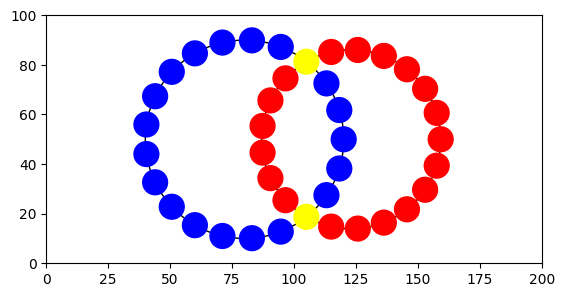

In [36]:
# Let's see the solution state
plot_wreath212121(329,True)

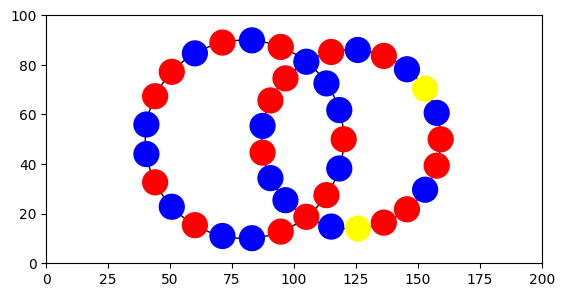

In [37]:
# puzzle 329
plot_wreath212121(329)

In [46]:
puzzle_idx = 329
example = puzzles.loc[puzzle_idx]
moves = info.loc[info['puzzle_type'] == example['puzzle_type']]['allowed_moves'].values[0]
moves = eval(moves)
moves_ = moves.copy()
for m, d in moves_.items():
    moves[f'-{m}'] = list(np.argsort(d))
# solution_steps = ss.loc[puzzle_idx]['moves']
# solution_steps = "l.r.l.l.r.l.l.l.l.l.l.r.l.l.r.r.l.r.r.r.r.r.r.r.r.r.r.r.r.r.r.l"
# solution_steps ="-l.-r.-r.l.r.l.-r.-r.-r.l.l.-r.-r.-r.l.l.l.-r.-r.l.l.l.-r.-r.-r.-r.l.l.r"
# solution_steps ="l.r.r.r.r.r.l.l.r.r.r.l.l.l.l.l.l.l.l.r.r.r.r.r.r.r.r.r.l.l.l.l"
solution_steps ="l.r.r.r.r.r.l.l.r.r.r.l.l.l.l.l.l.l.l.r.r.r.r.r.r.r.r.r.l.l.l.l.-r.-r.-r.-r.-l.-l.-l.-r.-r.-r.-r.l.l.l.-r.-r.-r.-l.-l.-r.l.r.-l.r.r.r.r.r.r.-l"
initialstate = puzzles.loc[puzzle_idx]['initial_state'].split(";")
now = np.array(initialstate)
states = [now]
for move in solution_steps.split('.'):
    now = now[moves[move]]
    states.append(now)
steps = list(range(len(states)))
def plot_wreath2121_329_interact(istate):
    node_types = states[istate]
    color_map = {'A':'blue', 'B':'red', 'C':'yellow'}

    circle1 = plt.Circle((x_center1, y_center1), radius1, color='black', fill = False)
    circle2 = plt.Circle((x_center2, y_center2), radius2, color='black', fill = False)
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    ax.set_aspect('equal', adjustable='box')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    for i, (x, y) in enumerate(zip(x_nodes,y_nodes)):
        circle_node = plt.Circle((x, y), 5, color=color_map[node_types[i]], fill = True)
        ax.add_patch(circle_node)


    plt.xlim([0, 200])
    plt.ylim([0, 100])


    plt.show()

#interactive_plot = interactive(plot_wreath2121_329_interact, istate=widgets.IntSlider(value=0,
#                                               min=0,
#                                               max=len(states)-1,
#                                               step=1))
interactive_plot = interactive(plot_wreath2121_329_interact, istate=steps)
interactive_plot

interactive(children=(Dropdown(description='istate', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

# ソルバー
- http://kociemba.org/cube.htm

In [28]:
# import optimal.solver as sv
# import twophase.solver as tsv

In [29]:
# import pandas as pd
# import numpy as np
# from sympy.combinatorics import Permutation

# p = 'santa-2023/'
# path = pd.read_csv(p + 'puzzles.csv')
# info = pd.read_csv(p + 'puzzle_info.csv')
# sub = pd.read_csv(p+'sample_submission.csv')

# info['allowed_moves_count'] = info['allowed_moves'].map(lambda x: {k: Permutation(v) for k, v in eval(x).items()})
# paths = pd.merge(path, info, how='left', on='puzzle_type')
# paths = pd.merge(paths, sub, how='left', on='id')

In [207]:
# # https://www.kaggle.com/code/wrrosa/santa-2023-kociemba-s-two-phase-algo-1-116-550
# U = ['U', 'F', 'R', 'B', 'L', 'D']
# def state2ubl(state):
#     dct = {}
#     for u in range(len(U)):
#         dct[state.split(';')[4+u*9]] = U[u]
#     s = ''.join([dct[f] for f in state.split(';')])
#     return s[:9] + s[18:27] + s[9:18] + s[45:] + s[36:45] + s[27:36]

In [208]:
# moves = eval(info.loc[info['puzzle_type'] == 'cube_3/3/3']['allowed_moves'].values[0])
# for move in list(moves):
#     moves['-'+move] = np.argsort(moves[move]).tolist()

# M = {}
# M["U"] = '-d2'
# M["R"] = "r0"
# M["B"] = "-f2"
# M["F"] = "f0"
# M["L"] = "-r2"
# M["D"] = "d0"
# for m in list(M):
#     M[m+"2"] = M[m] + '.' + M[m]
#     if "-" in M[m]:
#         M[m+"'"] = M[m].replace("-","")
#     else:
#         M[m+"'"] = "-"+M[m]

In [30]:
# for i in paths.loc[paths['puzzle_type'] == 'cube_3/3/3'].iterrows():
#     try:
#         id = i[1]['id']
#         cur_state = i[1]['initial_state']
        
#         sol = sv.solve(state2ubl(cur_state))

#         new_state = cur_state
#         mmoves = '.'.join([M[m] for m in sol.split(' ')])

#         for move in mmoves.split('.'):
#             new_state = ';'.join(list(np.asarray(new_state.split(';'))[np.array(moves[move])]))
#         I = ['r0.r1.r2','d0.d1.d2','f0.f1.f2']
#         for init_moves in [''] + I + [i1 + '.' + i2 for i1 in I for i2 in I]+ [i1 + '.' + i2+ '.' + i3 for i1 in I for i2 in I for i3 in I]+ [i1 + '.' + i2+ '.' + i3 + '.' + i4 for i1 in I for i2 in I for i3 in I for i4 in I]:
#             temp_state = new_state
#             if len(init_moves) > 0:
#                 for move in init_moves.split('.'):
#                     temp_state = ';'.join(list(np.asarray(temp_state.split(';'))[np.array(moves[move])]))

#             if temp_state == i[1]['solution_state']:
#                 print(f'solved id: {id}')
#                 if len(init_moves) > 0:
#                     mmoves += '.' + init_moves
#                 if len(paths.iloc[id,7].split('.')) > len(mmoves.split('.')):
#                     print(f"improved: new length {len(mmoves.split('.'))} vs current length {len(paths.iloc[id,7].split('.'))}")
#                     paths.iloc[id,7] = mmoves
#                 break
#     except:
#         pass

In [31]:
# class ParticipantVisibleError(Exception):
#     pass

# def score(sol) -> float:
#     total_num_moves = 0
#     for i in range(len(sol)):
#         puzzle_id=sol['id'][i]
#         moves = sol.moves[i].split('.')
#         allowed_moves=sol.allowed_moves_count[i]
#         state = sol.initial_state[i].split(';')
#         solution_state=sol.solution_state[i].split(';')
#         num_wildcards=sol.num_wildcards[i]
#         for m in moves:
#             power = 1
#             if m[0] == "-":
#                 m = m[1:]
#                 power = -1
#             try:
#                 p = allowed_moves[m]
#             except KeyError:
#                 raise ParticipantVisibleError(f"{m} is not an allowed move for {puzzle_id}.")
#             state = (p ** power)(state)
#         num_wrong_facelets = sum(not(s == t) for s, t in zip(solution_state, state))
#         if num_wrong_facelets > num_wildcards:
#             print(puzzle_id, num_wrong_facelets, puzzle.num_wildcards)
#             raise ParticipantVisibleError(f"Submitted moves do not solve {puzzle_id}.")
#         total_num_moves += len(moves)
#     return total_num_moves

In [ ]:
# %%time
# score(paths)

In [32]:
# paths[['id','moves']].to_csv('solver_result.csv', index=False)

In [168]:
cubestring="UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB"
tsv.solve(cubestring)

'(0f)'

In [171]:
solver_input.at[30,"solution_state"]

'UUUUUUUUUFFFFFFFFFRRRRRRRRRBBBBBBBBBLLLLLLLLLDDDDDDDDD'

In [169]:
cubestring="UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB"
tsv.solve(cubestring)

'(0f)'

In [139]:
p = './santa-2023/'
puzzles = pd.read_csv(p+'puzzles.csv')
puzzle_info = pd.read_csv(p+'puzzle_info.csv')

In [140]:
puzzles.loc[puzzles["puzzle_type"]=="cube_3/3/3"].drop_duplicates(subset=["solution_state"])

,id,puzzle_type,solution_state,initial_state,num_wildcards
30,30,cube_3/3/3,A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;...,A;A;E;C;F;F;C;C;C;D;B;D;D;B;A;B;F;F;A;E;B;D;E;...,0
130,130,cube_3/3/3,A;B;A;B;A;B;A;B;A;B;C;B;C;B;C;B;C;B;C;D;C;D;C;...,C;B;D;B;B;C;F;E;A;B;D;D;B;C;A;A;E;B;E;F;A;F;A;...,0
140,140,cube_3/3/3,N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...,N33;N7;N42;N19;N4;N52;N9;N48;N0;N38;N43;N29;N2...,6


In [146]:
from collections import Counter
Counter(puzzles.at[30,"initial_state"])

Counter({'A': 9, ';': 53, 'E': 9, 'C': 9, 'F': 9, 'D': 9, 'B': 9})

In [141]:
# puzzles.at[30, "solution_state"].replace(";","")
puzzles.at[30, "solution_state"]

'A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;C;C;C;C;D;D;D;D;D;D;D;D;D;E;E;E;E;E;E;E;E;E;F;F;F;F;F;F;F;F;F'

In [124]:
# AAAAAAAAABBBBBBBBBCCCCCCCCCDDDDDDDDDEEEEEEEEEFFFFFFFFF
tb = [['A','y','u'],
      ['B','g','f'],
      ['C','o','r'],
      ['D','b','b'],
      ['E','r','l'],
      ['F','w','d']]


In [157]:
mapping={
    "A":"U",
    "B":"F",
    "C":"R",
    "D":"B",
    "E":"L",
    "F":"D"
}

In [158]:
solver_input=puzzles[puzzles["solution_state"]=="A;A;A;A;A;A;A;A;A;B;B;B;B;B;B;B;B;B;C;C;C;C;C;C;C;C;C;D;D;D;D;D;D;D;D;D;E;E;E;E;E;E;E;E;E;F;F;F;F;F;F;F;F;F"   ]
solver_input["solution_state"]=solver_input["solution_state"].str.replace(";","").map(
    lambda x: "".join([mapping[c] for c in x])
)
solver_input["initial_state"]=solver_input["initial_state"].str.replace(";","").str.replace(";","").map(
    lambda x: "".join([mapping[c] for c in x])
)

C:\cygwin64\tmp\ipykernel_6012\3019945060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solver_input["solution_state"]=solver_input["solution_state"].str.replace(";","").map(
C:\cygwin64\tmp\ipykernel_6012\3019945060.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solver_input["initial_state"]=solver_input["initial_state"].str.replace(";","").str.replace(";","").map(


In [163]:
Counter(solver_input.at[30,"initial_state"]), Counter(solver_input.at[30,"solution_state"])

(Counter({'U': 9, 'L': 9, 'R': 9, 'D': 9, 'B': 9, 'F': 9}),
 Counter({'U': 9, 'F': 9, 'R': 9, 'B': 9, 'L': 9, 'D': 9}))

In [167]:
tsv.solve(solver_input.at[30,"initial_state"])

'Error: Some edges are undefined.'

In [164]:
answers=[]
for i, row in solver_input.iterrows():
    ans=tsv.solve(row["initial_state"])
    print(ans)
    answers.append(ans)

Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Some edges are undefined.
Error: Som